# Multidimensional Regression on LHC collision jets Submission

Add your solution below!

To run the notebook in VS Code, you can click on the `Run All` button in the toolbar. You may need to select the kernel to run. When prompted select `Python Environments` and then `.venv` (Should be starred).

> Note: You can add dependencies to your virtual environment by running `aqora add <dependency name>` or editing the `pyproject.toml` at the root of the project

Once you're ready, you can open a terminal by clicking `Terminal` and then `New Terminal` in the context bar at the very top. To test your solution, run

```bash
aqora test
```

Finally, once all the tests are passing, to submit to **Aqora** run

```bash
aqora upload
```


## libraries

In [27]:
import h5py
from vector import Vector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [28]:
partons_fp ='/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/cern-2025-challenge-2/.aqora/data/data/pp-z-to-jets-500K-54167.h5'
jets_partons_fp = '/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/cern-2025-challenge-2/.aqora/data/data/pp-z-to-jets-500K-57246.h5' 

Custom LorentzVectors just a test

In [29]:
class LorentzVector:
    def __init__(self, px, py, pz, E):
        self.px = px
        self.py = py
        self.pz = pz
        self.E = E

    def pt(self):
        return np.sqrt(self.px**2 + self.py**2)

    def eta(self):
        p = np.sqrt(self.px**2 + self.py**2 + self.pz**2)
        return 0.5 * np.log((p + self.pz) / (p - self.pz))

    def phi(self):
        return np.arctan2(self.py, self.px)

In [30]:
def compute_derived_quantities_partons(df):
        results = []
        for index, row in df.iterrows():
            parton_1 = LorentzVector(px=row['parton_0_px'], py=row['parton_0_py'], pz=row['parton_0_pz'], E=row['parton_0_E'])
            parton_2 = LorentzVector(px=row['parton_1_px'], py=row['parton_1_py'], pz=row['parton_1_pz'], E=row['parton_1_E'])
            pt_1 = parton_1.pt()
            pt_2 = parton_2.pt()
            eta_1 = parton_1.eta()
            eta_2 = parton_2.eta()
            phi_1 = parton_1.phi()
            phi_2 = parton_2.phi()
            delta_r = compute_delta_r(eta_1, phi_1, eta_2, phi_2)
            results.append({
                'event_id': index,
                'parton_1_pt': pt_1,
                'parton_2_pt': pt_2,
                'parton_1_eta': eta_1,
                'parton_2_eta': eta_2,
                'parton_1_phi': phi_1,
                'parton_2_phi': phi_2,
                'delta_r': delta_r
            })

        return pd.DataFrame(results)


In [31]:
def compute_derived_quantities_jets(df, num_max_jets):
        results = []
        for index, row in df.iterrows():
            jet_data = []
            for j in range(num_max_jets):
                if row[f'jet_{j}_px'] == 0 and row[f'jet_{j}_py'] == 0 and row[f'jet_{j}_pz'] == 0 and row[f'jet_{j}_E'] == 0:
                    continue 
                jet = LorentzVector(px=row[f'jet_{j}_px'], py=row[f'jet_{j}_py'], pz=row[f'jet_{j}_pz'], E=row[f'jet_{j}_E'])
                jet_data.append({
                    f'jet_{j}_pt': jet.pt(),
                    f'jet_{j}_eta': jet.eta(),
                    f'jet_{j}_phi': jet.phi()
                })
            results.append({'event_id': index, **{k: v for d in jet_data for k, v in d.items()}})

        return pd.DataFrame(results)

## Parton jets relationship 

#### added to determing the relationship between the parton events and their respective jets

In [32]:
def analyze_parton_jet_relationship_to_csv(merged_df):
    merged_df['pt_diff_1'] = merged_df['parton_1_pt'] - merged_df['jet_0_pt']
    merged_df['pt_ratio_1'] = merged_df['parton_1_pt'] / merged_df['jet_0_pt']
    merged_df['eta_diff_1'] = merged_df['parton_1_eta'] - merged_df['jet_0_eta']
    merged_df['phi_diff_1'] = merged_df['parton_1_phi'] - merged_df['jet_0_phi']

    merged_df['pt_diff_2'] = merged_df['parton_2_pt'] - merged_df['jet_1_pt']
    merged_df['pt_ratio_2'] = merged_df['parton_2_pt'] / merged_df['jet_1_pt']
    merged_df['eta_diff_2'] = merged_df['parton_2_eta'] - merged_df['jet_1_eta']
    merged_df['phi_diff_2'] = merged_df['parton_2_phi'] - merged_df['jet_1_phi']

    relationship_df = merged_df[['event_id', 'pt_diff_1', 'pt_ratio_1', 'eta_diff_1', 'phi_diff_1',
                                 'pt_diff_2', 'pt_ratio_2', 'eta_diff_2', 'phi_diff_2']]
    relationship_df.to_csv("/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/datasets/parton_jet_relationships.csv")
    print("Parton-Jet Relationship DataFrame:")
    print(relationship_df.head())

In [33]:
def analyze_parton_jet_relationship(merged_df):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(merged_df['parton_1_pt'], merged_df['jet_0_pt'], alpha=0.5, label='Parton 1 vs Jet 0')
    plt.xlabel('Parton 1 pT')
    plt.ylabel('Leading Jet pT')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(merged_df['parton_2_pt'], merged_df['jet_1_pt'], alpha=0.5, label='Parton 2 vs Jet 1')
    plt.xlabel('Parton 2 pT')
    plt.ylabel('Subleading Jet pT')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [34]:
def process_hep_data(file_path):
    with h5py.File(file_path, 'r') as f:
        print(f"Processing {file_path}")
        data_file_name = file_path.split('/')[-1]
        data_file = data_file_name.split('-')[-1]
        print(f'Keys {f.keys()}')

        if 'partons' in f and 'jets' in f:
            print(f"Processing partons and jets {data_file}")

            partons_data = f['partons'][:]
            column_names = [f'parton_{i}_{component}' for i in range(partons_data.shape[1]) for component in ['px', 'py', 'pz', 'E', 'id', 'charge']]
            partons_df = pd.DataFrame(partons_data.reshape(partons_data.shape[0], -1), columns=column_names)
            partons_derived_df = compute_derived_quantities_partons(partons_df)
            partons_df['event_id'] = np.arange(partons_data.shape[0])
            partons_df = pd.merge(partons_df, partons_derived_df, on='event_id')
            partons_df.to_csv(f"/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/datasets/{data_file}_partons_df.csv")
            print("Partons DataFrame with Derived Quantities:")
            print(partons_df.head())
            jets_data = f['jets'][:]
            num_max_jets = jets_data.shape[1]
            jet_column_names = [f'jet_{j}_{component}' for j in range(num_max_jets) for component in ['px', 'py', 'pz', 'E']]
            jets_df = pd.DataFrame(jets_data.reshape(jets_data.shape[0], -1), columns=jet_column_names)
            jets_derived_df = compute_derived_quantities_jets(jets_df, num_max_jets)
            jets_df['event_id'] = np.arange(jets_df.shape[0])
            jets_df = pd.merge(jets_df, jets_derived_df, on='event_id')
            jets_df.to_csv(f"/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/datasets/{data_file}_jets_df.csv")
            print("Jets DataFrame with Derived Quantities:")
            print(jets_df.head())
            merged_df = pd.merge(partons_df, jets_df, on='event_id')
            analyze_parton_jet_relationship(merged_df)
            analyze_parton_jet_relationship_to_csv(merged_df)

        elif 'partons' in f:
            print(f"Processing partons {data_file}")
            partons_data = f['partons'][:]
            column_names = [f'parton_{i}_{component}' for i in range(partons_data.shape[1]) for component in ['px', 'py', 'pz', 'E', 'id', 'charge']]
            partons_df = pd.DataFrame(partons_data.reshape(partons_data.shape[0], -1), columns=column_names)
            partons_derived_df = compute_derived_quantities_partons(partons_df)
            partons_df['event_id'] = np.arange(partons_data.shape[0])
            partons_df = pd.merge(partons_df, partons_derived_df, on='event_id')
            partons_df.to_csv(f"/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/datasets/{data_file}_partons_df.csv")
            print("Partons DataFrame with Derived Quantities:")
            print(partons_df.head())

        elif 'jets' in f:
            print(f"Processing jets {data_file}")
            jets_data = f['jets'][:]
            num_max_jets = jets_data.shape[1]
            jet_column_names = [f'jet_{j}_{component}' for j in range(num_max_jets) for component in ['px', 'py', 'pz', 'E']]
            jets_df = pd.DataFrame(jets_data.reshape(jets_data.shape[0], -1), columns=jet_column_names)
            jets_derived_df = compute_derived_quantities_jets(jets_df, num_max_jets)
            jets_df['event_id'] = np.arange(jets_df.shape[0])
            jets_df = pd.merge(jets_df, jets_derived_df, on='event_id')
            jets_df.to_csv(f"/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/datasets/{data_file}_jets_df.csv")
            print("Jets DataFrame with Derived Quantities:")
            print(jets_df.head())

        else:
            print("Neither 'partons' nor 'jets' dataset found in the file.")


In [35]:
def compute_delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = phi1 - phi2
    delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi
    delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
    return delta_r

## partons-jets (parton-level) data

In [36]:
process_hep_data(partons_fp)

Processing /Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/cern-2025-challenge-2/.aqora/data/data/pp-z-to-jets-500K-54167.h5
Keys <KeysViewHDF5 ['partons']>
Processing partons 54167.h5
Partons DataFrame with Derived Quantities:
   parton_0_px  parton_0_py  parton_0_pz   parton_0_E  parton_0_id  \
0  2670.621931          0.0          0.0  2670.621931          2.0   
1    20.599678          0.0          0.0    20.599678         21.0   
2   734.970867          0.0          0.0   734.970867         -2.0   
3    54.579647          0.0          0.0    54.579647         21.0   
4   988.044224          0.0          0.0   988.044224          1.0   

   parton_0_charge  parton_1_px  parton_1_py  parton_1_pz  parton_1_E  \
0         0.666667     8.880119          0.0          0.0   -8.880119   
1         0.000000   447.007332          0.0          0.0 -447.007332   
2        -0.666667    30.659213          0.0          0.0  -30.659213   
3         0.000000   132.425363          0.0

Processing /Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/cern-2025-challenge-2/.aqora/data/data/pp-z-to-jets-500K-57246.h5
Keys <KeysViewHDF5 ['jets', 'partons']>
Processing partons and jets 57246.h5
Partons DataFrame with Derived Quantities:
   parton_0_px  parton_0_py  parton_0_pz   parton_0_E  parton_0_id  \
0    40.810952          0.0          0.0    40.810952         21.0   
1   208.271873          0.0          0.0   208.271873         21.0   
2  2214.297147          0.0          0.0  2214.297147          4.0   
3  1106.889921          0.0          0.0  1106.889921          1.0   
4    25.916341          0.0          0.0    25.916341         -3.0   

   parton_0_charge  parton_1_px  parton_1_py  parton_1_pz  parton_1_E  \
0         0.000000   387.309839          0.0          0.0 -387.309839   
1         0.000000    35.051356          0.0          0.0  -35.051356   
2         0.666667     5.174153          0.0          0.0   -5.174153   
3        -0.333333    13.73

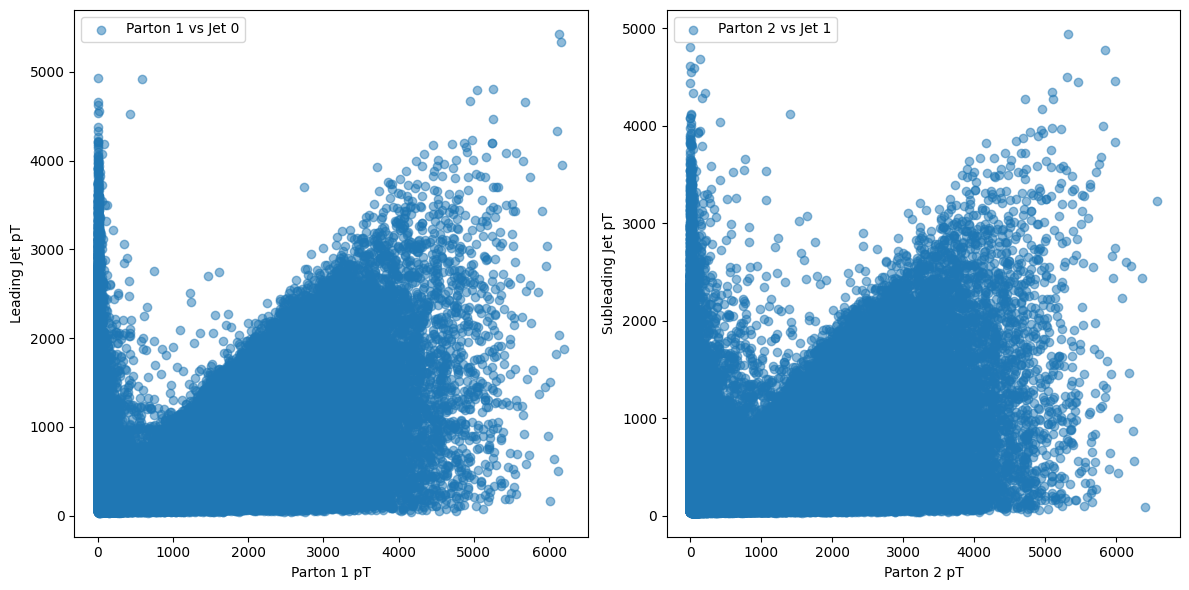

Parton-Jet Relationship DataFrame:
   event_id    pt_diff_1  pt_ratio_1  eta_diff_1  phi_diff_1   pt_diff_2  \
0         0  -174.287017    0.189732   -0.191915    0.437148  191.969102   
1         1   137.309468    2.934961    0.446646   -0.613610  -43.748715   
2         2  1462.027297    2.943488    0.077942    0.034509 -438.468946   
3         3   941.376141    6.687600    0.293669    0.397117 -597.965155   
4         4   -96.508653    0.211692   -0.146407   -0.646037  106.482106   

   pt_ratio_2  eta_diff_2  phi_diff_2  
0    1.982740    0.178169   -0.336610  
1    0.444814   -0.486894    0.388990  
2    0.011663   -0.099127    0.008646  
3    0.022449   -0.050312   -0.042644  
4    1.607688   -0.089862    0.338962  


In [37]:
process_hep_data(jets_partons_fp)

In [ ]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()

solution = pd.DataFrame({
    "EventID": np.arange(0, n_events),
    "n_jets_pred": rng.integers(low=0, high=10, size=n_events),
    "leading_pt_pred": rng.uniform(low=30, high=130, size=n_events),
    "subleading_pt_pred": rng.uniform(low=30, high=130, size=n_events),
})

In [ ]:
import io

output = io.StringIO()
solution.to_csv(output)
output = output.getvalue()